In [ ]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import shutil
import os
import time
import sys
from pathlib import Path
import functools
print = functools.partial(print, flush=True)
import numpy as np


interest_num = [3,6]
img_size = 4
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1
inference_batch_size = 1

print("="*100)
print("Demo 2 on MNIST. This script is QF-Map for Quantum Circuit from Weights.")
print("\tStart at:",time.strftime("%m/%d/%Y %H:%M:%S"))
print("\tProblems and issues, please contact Dr. Weiwen Jiang (wjiang2@nd.edu)")
print("\tEnjoy and Good Luck!")
print("="*100)
print()


In [ ]:
def modify_target(target):
    for j in range(len(target)):
        for idx in range(len(interest_num)):
            if target[j] == interest_num[idx]:
                target[j] = idx
                break
    
    new_target = torch.zeros(target.shape[0],2)
        
    for i in range(target.shape[0]):        
        if target[i].item() == 0:            
            new_target[i] = torch.tensor([1,0]).clone()     
        else:
            new_target[i] = torch.tensor([0,1]).clone()
               
    return target,new_target

def select_num(dataset,interest_num):
    labels = dataset.targets #get labels
    labels = labels.numpy()
    idx = {}
    for num in interest_num:
        idx[num] = np.where(labels == num)
        
    fin_idx = idx[interest_num[0]]
    for i in range(1,len(interest_num)):           
        
        fin_idx = (np.concatenate((fin_idx[0],idx[interest_num[i]][0])),)
    
    fin_idx = fin_idx[0]    
    
    dataset.targets = labels[fin_idx]
    dataset.data = dataset.data[fin_idx]
    
    # print(dataset.targets.shape)
    
    dataset.targets,_ = modify_target(dataset.targets)
    # print(dataset.targets.shape)
    
    return dataset

def qc_input_trans(dataset):
    dataset.data = dataset.data
    return dataset


class ToQuantumData(object):
    def __call__(self, tensor):        
        data = tensor                
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len,vec_len)
        input_matrix[0] = input_vec
        input_matrix = input_matrix.transpose(0,1)        
        u,s,v = np.linalg.svd(input_matrix)    
        output_matrix = torch.tensor(np.dot(u,v))            
        output_data = output_matrix[:,0].view(1,img_size,img_size)    
        return output_data
    

class ToQuantumMatrix(object):
    def __call__(self, tensor):        
        data = tensor                
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len,vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0,1))        
        u,s,v = np.linalg.svd(input_matrix)    
        output_matrix = torch.tensor(np.dot(u,v))                        
        return output_matrix
                

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                transforms.ToTensor(),ToQuantumData()])
# transform = transforms.Compose([transforms.Resize((img_size,img_size)),
#                                 transforms.ToTensor(),ToQuantumData()])
# transform = transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
# choose the training and test datasets

# Path to MNIST Dataset
train_data = datasets.MNIST(root='../../pytorch/data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='../../pytorch/data', train=False,
                                  download=True, transform=transform)

train_data = select_num(train_data,interest_num)
test_data =  select_num(test_data,interest_num)

# train_data = qc_input_trans(train_data)

# imshow(torchvision.utils.make_grid(train_data[0][0]))
# 
# sys.exit(0)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)

def save_checkpoint(state, is_best, save_path, filename):
    filename = os.path.join(save_path, filename)
    torch.save(state, filename)
    if is_best:
        bestname = os.path.join(save_path, 'model_best.tar')
        shutil.copyfile(filename, bestname)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# functions to show an image
from matplotlib import cm


def imshow(img):
    img = img
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    
    plt.show()
    
    # image = np.asarray(npimg[0] * 255, np.uint8)    
    # 
    # im = Image.fromarray(image,mode="L")
    # im.save("32*32.jpg",cmap="gray") 
    # im = im.resize((4,4),Image.BILINEAR)    
    # 
    # plt.imshow(im,cmap='gray',)
    # 
    # trans_to_tensor = transforms.ToTensor()
    # trans_to_matrix = ToQuantumMatrix()
    # plt.show()
    # im.save("4*4.jpg",cmap="gray") 
    
    # print(trans_to_tensor(im))
    # for row in trans_to_matrix(trans_to_tensor(im)).tolist():
    #     for num in row:
    #         print(num,end=",")
    #     print()

#     
# for batch_idx, (data, target) in enumerate(test_loader):
#     torch.set_printoptions(threshold=sys.maxsize)
#     imshow(torchvision.utils.make_grid(data))
#     break




In [ ]:
from lib_qc import * 
from lib_util import *
from lib_net import *

# Network Architecture: 2 layers and each layer contains 2 neurons

img_size = 4
device = torch.device("cpu")
layers = [2, 2]

model = Net(img_size,layers,True,[[1,1,1,1],[1,1]],True,False,False,False,True).to(device)

resume_path="checkpoint_8_0.9573.pth.tar"
print("=> loading checkpoint from '{}'<=".format(resume_path))
checkpoint = torch.load(resume_path, map_location=device)
epoch_init, acc = checkpoint["epoch"], checkpoint["acc"]
model.load_state_dict(checkpoint["state_dict"])


for name, para in model.named_parameters():
    if "fc" in name:
        print(name,binarize(para))
    else:
        print(name, para)


for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    imshow(torchvision.utils.make_grid(data))
    # print(data)
    
    Q_InputMatrix = ToQuantumMatrix()(data)
    break

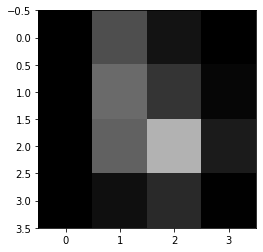

tensor([[[[0.0000, 0.3088, 0.0755, 0.0000],
          [0.0000, 0.4186, 0.2059, 0.0274],
          [0.0000, 0.3843, 0.6999, 0.1098],
          [0.0000, 0.0618, 0.1647, 0.0069]]]]) tensor([1])


In [101]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.extensions import XGate, UnitaryGate
import qiskit
from math import sqrt 
import math
import copy

def get_index_list(input,target):
    index_list = []
    try:
        beg_pos = 0
        while True:
            find_pos = input.index(target,beg_pos)
            index_list.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass    
    return index_list

def change_sign(sign,bin):
    affect_num = [bin]
    one_positions = []
    
    try:
        beg_pos = 0
        while True:
            find_pos = bin.index("1",beg_pos)
            one_positions.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:
        # print("Not Found")
        pass
    
    for k,v in sign.items():
        change = True
        for pos in one_positions:
            if k[pos]=="0":                
                change = False
                break
        if change:
            sign[k] = -1*v
    

def find_start(affect_count_table,target_num):
    for k in list(affect_count_table.keys())[::-1]:
        if target_num<=k:
            return k


def recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates):
    
    if start_point == target_num:
        # print("recursive_change: STOP")
        return
    
    gap = int(math.fabs(start_point-target_num))    
    step = find_start(affect_count_table,gap)
    change_sign(sign,affect_count_table[step])
    quantum_gates.append(affect_count_table[step])
    
    if direction=="r": 
        # print("recursive_change: From",start_point,"Right(-):",step)
        start_point = start_point - step
        direction = "l"
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
        
    else:        
        # print("recursive_change: From",start_point,"Left(+):",step)
        start_point = start_point + step
        direction = "r"
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
        
    

def guarntee_upper_bound_algorithm(sign,target_num,total_len,digits):        
    flag = "0"+str(digits)+"b"
    pre_num = 0
    affect_count_table = {}
    quantum_gates = []
    for i in range(digits):
        cur_num = pre_num + pow(2,i)
        pre_num = cur_num
        binstr_cur_num = format(cur_num,flag) 
        affect_count_table[int(pow(2,binstr_cur_num.count("0")))] = binstr_cur_num   
        
    if target_num in affect_count_table.keys():
        quantum_gates.append(affect_count_table[target_num])
        change_sign(sign,affect_count_table[target_num])    
    else:
        direction = "r"
        start_point = find_start(affect_count_table,target_num)
        quantum_gates.append(affect_count_table[start_point])
        change_sign(sign,affect_count_table[start_point])
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
    
    return quantum_gates

def qf_map_extract_from_weight(weights):    
    # Find Z control gates according to weights
    w = (weights.detach().cpu().numpy())
    total_len = len(w)
    target_num = np.count_nonzero(w == -1)
    if target_num > total_len/2:
        w = w*-1
    target_num = np.count_nonzero(w == -1)    
    digits = int(math.log(total_len,2))
    flag = "0"+str(digits)+"b"
    max_num = int(math.pow(2,digits))
    sign = {}
    for i in range(max_num):        
        sign[format(i,flag)] = +1
    quantum_gates = guarntee_upper_bound_algorithm(sign,target_num,total_len,digits)
    
    # for k,v in sign.items():
    #     print(k,v)
    # print(w)
        
    # Build the mapping from weight to final negative num 
    fin_sign = list(sign.values())
    fin_weig = [int(x) for x in list(w)]
    sign_neg_index = []    
    try:
        beg_pos = 0
        while True:
            find_pos = fin_sign.index(-1,beg_pos)
            sign_neg_index.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass    
    weight_neg_index = []
    try:
        beg_pos = 0
        while True:
            find_pos = fin_weig.index(-1,beg_pos)
            weight_neg_index.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass    
    map = {}
    for i in range(len(sign_neg_index)):
        map[sign_neg_index[i]] = weight_neg_index[i]
            
    # print(map)
    
    ret_index = list(range(len(fin_weig)))
    
    for k,v in map.items():
        old_val = ret_index[k] 
        ret_index[k] = v
        ret_index[v] = old_val
    

    return quantum_gates,ret_index
    
    
def extract_model(model):
    layer_prop = {}
    batch_adj_prop = {}
    indiv_adj_prop = {}
    for name, para in model.named_parameters():
        if "fc" in name:
            layer_id = int(name.split(".")[0].split("c")[1])
            layer_prop[layer_id] = [para.shape[1],para.shape[0],binarize(para)]            
        elif "qca" in name:            
            if "l_0_5" in name or "running_rot" in name:
                layer_id = int(name.split(".")[0].split("a")[1])
                layer_fun = name.split(".")[1]
                if layer_id not in batch_adj_prop.keys():
                    batch_adj_prop[layer_id] = {}
                batch_adj_prop[layer_id][layer_fun] = para
        else:            
            print(name, para)
    
    # print(layer_prop)
    # print(batch_adj_prop)

    # First layer
    first_layer_num = layer_prop[0][1]
    
    first_layer_input_q = int(math.log(layer_prop[0][0],2))
    first_layer_addition_q = max(first_layer_input_q-2,0)        
    first_layer_batch_q = 0    
    if 0 in batch_adj_prop.keys():
        first_layer_batch_q = 2
    
    first_layer_q = first_layer_num*(first_layer_input_q+first_layer_batch_q)
    
    # print(first_layer_q)
    
    # Second layer
    second_layer_num = layer_prop[1][1]
    second_layer_input_q = int(math.log(layer_prop[1][0],2))
    second_layer_addition_q = max(first_layer_input_q-2,0)        
    second_layer_batch_q = 0
    if 1 in batch_adj_prop.keys():
        second_layer_batch_q = 2

    second_layer_q = second_layer_num*(second_layer_input_q+second_layer_batch_q)
    # print(second_layer_q)
    
    return first_layer_q,second_layer_q,first_layer_input_q,layer_prop,batch_adj_prop,max(first_layer_addition_q,second_layer_addition_q)
    
# Main part

for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    imshow(torchvision.utils.make_grid(data))
    print(data,target)
    Q_InputMatrix = ToQuantumMatrix()(data)
    break

In [102]:
import qiskit_library

f,s,iq,nn_prop,bn_prop,aux = extract_model(model)

f_qr = QuantumRegister(f,"fLayer")
s_qr = QuantumRegister(s,"sLayer")
aux_qr = QuantumRegister(aux,"aux")

circ = QuantumCircuit(f_qr,s_qr,aux_qr)

# circ.append(UnitaryGate(Q_InputMatrix, label="iswap"), f_qr[iq:iq*2])

quantum_gates,ret_index = qf_map_extract_from_weight(nn_prop[0][2][0])
index = torch.LongTensor(ret_index)
Input0 = copy.deepcopy(Q_InputMatrix)
Input0 = Input0[index]
circ.append(UnitaryGate(Input0, label="Input0"), f_qr[0:iq])
qbits = f_qr[0:iq]
for gate in quantum_gates:
    z_count = gate.count("1")
    z_pos = get_index_list(gate,"1")
    if z_count==1:
        circ.z(qbits[z_pos[0]])
    elif z_count==2:
        circ.cz(qbits[z_pos[0]],qbits[z_pos[1]])
    elif z_count==3:
        qiskit_library.ccz(circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],aux_qr[0])
    elif z_count==4:
        qiskit_library.cccz(circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],qbits[z_pos[3]],aux_qr[0],aux_qr[1])
        

quantum_gates,ret_index = qf_map_extract_from_weight(nn_prop[0][2][1])
index = torch.LongTensor(ret_index)
Input1 = copy.deepcopy(Q_InputMatrix)
Input1 = Input1[index]
circ.append(UnitaryGate(Input1, label="Input1"), f_qr[iq:iq*2])
qbits = f_qr[iq:iq*2]
for gate in quantum_gates:
    z_count = gate.count("1")
    z_pos = get_index_list(gate,"1")
    if z_count==1:
        circ.z(qbits[z_pos[0]])
    elif z_count==2:
        circ.cz(qbits[z_pos[0]],qbits[z_pos[1]])
    elif z_count==3:
        qiskit_library.ccz(circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],aux_qr[0])
    elif z_count==4:
        qiskit_library.cccz(circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],qbits[z_pos[3]],aux_qr[0],aux_qr[1])
        


print(circ)

print(Q_InputMatrix.flatten())
print("=="*10)
print(Input0.flatten())
print("=="*10)
print(Input1.flatten())


             ┌──────────┐                                       
fLayer_0: |0>┤0         ├─────■─────────────────■───────────────
             │          │     │                 │               
fLayer_1: |0>┤1         ├─────■─────────────────■───────────────
             │  unitary │     │                 │               
fLayer_2: |0>┤2         ├─■───┼────■───────■────┼───────────────
             │          │ │   │    │       │    │               
fLayer_3: |0>┤3         ├─■───┼────┼───■───┼────┼───────────────
             ├──────────┤     │    │   │   │    │               
fLayer_4: |0>┤0         ├─────┼────┼───┼───┼────┼───────────────
             │          │     │    │   │   │    │               
fLayer_5: |0>┤1         ├─────┼────┼───┼───┼────┼────■───────■──
             │  unitary │     │    │   │   │    │    │       │  
fLayer_6: |0>┤2         ├─────┼────┼───┼───┼────┼────■───────■──
             │          │     │    │   │   │    │    │       │  
fLayer_7: |0>┤3         ├